# Library Dependencies

In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

#Models
import xgboost as xgb
from keras.applications.vgg16 import VGG16

# Metrics
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
pd.set_option('display.max_columns', None)

# Import Images and Output Labels

In [2]:
filepath = 'sampleCaptchas/input'
images = []
for file in os.listdir(filepath):
    if file.endswith('100.jpg'):
        continue
    if file.endswith('.jpg'):
        img = Image.open(os.path.join(filepath, file))
        images.append(img)
        
g_images = [ImageOps.grayscale(img) for img in images]
numpy_images = [np.array(g_img) for g_img in g_images]
pd_images = [pd.Series(n_img.flatten()) for n_img in numpy_images]

filepath = 'sampleCaptchas/output'
texts = []
for file in os.listdir(filepath):
    if file.endswith('.txt'):
        with open(os.path.join(filepath, file), 'r', encoding='utf-8') as f:
            text = f.readlines()[0].strip()
        texts.append(text)
        
# texts.insert(11, 'YMB1Q')
texts.insert(21, 'CL69V')
for i, (image, text) in enumerate(zip(images, texts)):
    print(i, text)
    display(image)

0 EGYK4


1 GRC35


2 6O5W1


3 J627C


4 VLI2C


5 O1R7Q


6 OYTAD


7 ZRMQU


8 N9DQS


9 ZGJS3


10 GZMBA


11 J14DM


12 PQ9AE


13 VWZDO


14 WGST7


15 XKMS2


16 1D2KB


17 20BHQ


18 OAH0V


19 5I8VE


20 Z97ME


21 CL69V


22 HCE91


23 WELXV


24 UHVFO


## Data Exploration

Apply statistical methods to obtain summary statistics for each pixel

In [6]:
df = pd.concat(pd_images, axis=1).transpose()

In [7]:
df_stats = df.describe()

In [5]:
df_stats.head()

0      1      2      3      4      5      6      7      8      9     \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   255.0  250.0  254.0  250.0  254.0  255.0  253.0  254.0  255.0  255.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    255.0  250.0  254.0  250.0  254.0  255.0  253.0  254.0  255.0  255.0   
25%    255.0  250.0  254.0  250.0  254.0  255.0  253.0  254.0  255.0  255.0   

        10     11     12     13     14     15     16     17     18     19    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   255.0  250.0  255.0  249.0  255.0  253.0  254.0  233.0  255.0  249.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    255.0  250.0  255.0  249.0  255.0  253.0  254.0  233.0  255.0  249.0   
25%    255.0  250.0  255.0  249.0  255.0  253.0  254.0  233.0  255.0  249.0   

        20     21     22     23     24     25     26     27     28     29    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   255.0  239.0  195.0  247.0  245.0  249.0  252.0  247.0  254.0  255.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    255.0  239.0  195.0  247.0  245.0  249.0  252.0  247.0  254.0  255.0   
25%    255.0  239.0  195.0  247.0  245.0  249.0  252.0  247.0  254.0  255.0   

        30     31     32     33     34     35     36     37     38     39    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   246.0  254.0  255.0  178.0  203.0  192.0  187.0  195.0  190.0  189.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    246.0  254.0  255.0  178.0  203.0  192.0  187.0  195.0  190.0  189.0   
25%    246.0  254.0  255.0  178.0  203.0  192.0  187.0  195.0  190.0  189.0   

        40     41     42     43     44     45     46     47     48     49    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   193.0  196.0  188.0  186.0  201.0  180.0  255.0  255.0  240.0  255.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    193.0  196.0  188.0  186.0  201.0  180.0  255.0  255.0  240.0  255.0   
25%    193.0  196.0  188.0  186.0  201.0  180.0  255.0  255.0  240.0  255.0   

        50     51     52     53     54     55     56     57     58     59    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   250.0  255.0  255.0  247.0  252.0  248.0  245.0  255.0  242.0  251.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    250.0  255.0  255.0  247.0  252.0  248.0  245.0  255.0  242.0  251.0   
25%    250.0  255.0  255.0  247.0  252.0  248.0  245.0  255.0  242.0  251.0   

        60     61     62     63     64     65     66     67     68     69    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   255.0  253.0  255.0  255.0  255.0  255.0  254.0  255.0  248.0  255.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    255.0  253.0  255.0  255.0  255.0  255.0  254.0  255.0  248.0  255.0   
25%    255.0  253.0  255.0  255.0  255.0  255.0  254.0  255.0  248.0  255.0   

        70     71     72     73     74     75     76     77     78     79    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   250.0  253.0  250.0  251.0  250.0  250.0  255.0  255.0  242.0  249.0   
std      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
min    250.0  253.0  250.0  251.0  250.0  250.0  255.0  255.0  242.0  249.0   
25%    250.0  253.0  250.0  251.0  250.0  250.0  255.0  255.0  242.0  249.0   

        80     81     82     83     84     85     86     87     88     89    \
count   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   25.0   
mean   255.0  255.0  187.0  252.0  255.0  255.0  2

Create overall mask to extract alphanumerals

In [8]:
row_mask = np.array(list(map(lambda x: not all(x), (df_stats.loc['min'] > 0).values.reshape(30, 60))))

In [9]:
def all_False(arr):
    return not all(arr)

col_mask = np.array(list(map(all_False, (df_stats.loc['min'] > 0).values.reshape(30, 60).T)))

Orignal Image

In [10]:
images[0]

Extracted only captcha Alphanumerals

In [12]:
Image.fromarray(np.uint8(numpy_images[0][(np.expand_dims(row_mask, axis=1) * np.expand_dims(col_mask, axis=0))].reshape(10,40)))

Obtain each individual mask for each alphanumeral position

In [14]:
col_mask

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False])

In [15]:
def get_true_positions(c_mask):
    res = []
    bool_true_start = False
    for i, boo in enumerate(c_mask):
        if boo == True:
            if bool_true_start == False:
                bool_true_start = True
                start_pos = i
        else:
            if bool_true_start:
                bool_true_start = False
                end_pos = i
                res.append((start_pos, end_pos))
                
    return res

def create_individual_masks(pos, c_mask):
    start, end = pos
    res = [boo if ((i >= start) and (i < end)) else False for i, boo in enumerate(c_mask)]
    return np.array(res)

masks = []

for positions in get_true_positions(col_mask):
    masks.append(np.expand_dims(row_mask, axis=1) * np.expand_dims(create_individual_masks(positions, col_mask), axis=0))

Example: First alphabet extraction

In [17]:
Image.fromarray(np.uint8(numpy_images[0][masks[0]].reshape(10,8)))

#### Map each input alphabet to output and compare

Extract alphabets and numbers from all input examples and compare each alphabet and number with its own if there are more than one example for each of them

In [19]:
alphabet_dict = {}

checker = set()

for image, text in zip(numpy_images, texts):
    for mask, alphabet in zip(masks, text):
        alpha = image[mask].reshape(10,8)
        if alphabet not in alphabet_dict:
            alphabet_dict[alphabet] = []
        alphabet_dict[alphabet].append(alpha)
        if len(alphabet_dict[alphabet]) > 1:
            checker.add(alphabet)
        
for alphabet in list(checker):
    alphabet_set = alphabet_dict[alphabet]
    tmp = [alpha.flatten() for alpha in alphabet_set]
    tmp = all([all(tmp[0] == alpha) for alpha in tmp])
    if not tmp:
        print(f'Not all alphabet extractions for {alphabet} are the same! D:')

Not all alphabet extractions for 2 are the same! D:
Not all alphabet extractions for D are the same! D:
Not all alphabet extractions for V are the same! D:
Not all alphabet extractions for T are the same! D:
Not all alphabet extractions for J are the same! D:
Not all alphabet extractions for R are the same! D:
Not all alphabet extractions for Y are the same! D:
Not all alphabet extractions for 9 are the same! D:
Not all alphabet extractions for O are the same! D:
Not all alphabet extractions for I are the same! D:
Not all alphabet extractions for 6 are the same! D:
Not all alphabet extractions for 3 are the same! D:
Not all alphabet extractions for Z are the same! D:
Not all alphabet extractions for U are the same! D:
Not all alphabet extractions for W are the same! D:
Not all alphabet extractions for K are the same! D:
Not all alphabet extractions for C are the same! D:
Not all alphabet extractions for 0 are the same! D:
Not all alphabet extractions for M are the same! D:
Not all alph

Example for 'E':

In [20]:
for e in alphabet_dict['E']:
    display(Image.fromarray(np.uint8(e)))
    print(e)

[[  0   0  18   0   3  18   0 197]
 [  0   0 250 248 248 237 250 188]
 [  2  15 250 255 245 255 255 173]
 [  0   0 249 255 231 255 243 178]
 [  0   0   2   0  10   0 235 213]
 [  4   2 247 179 207 184 182 220]
 [  8   1 255 199 232 251 255 184]
 [  0   0 253 195 255 255 253 185]
 [  5  31 233 190 202 179 203 197]
 [  2   0   8   0   0   0   8 193]]


[[  0  15   5   0   3   0   0 203]
 [  4   5 227 255 255 255 253 182]
 [  0   0 255 252 244 178 195 196]
 [  0   4 237 255 255 211 250 243]
 [  0   7   1   0   0   8 252 255]
 [  0   0 255 255 245 193 255 254]
 [  2  21 237 255 247 209 239 254]
 [  0   0 255 252 255 194 255 254]
 [  6   7 255 255 255 184 251 254]
 [ 14   0   0   0   0   0  18 254]]


[[  0  15   5   0   3   0   0 203]
 [  4   5 227 255 255 255 253 182]
 [  0   0 255 252 244 178 195 196]
 [  0   4 237 255 255 211 250 243]
 [  0   7   1   0   0   8 252 255]
 [  0   0 255 255 245 193 255 254]
 [  2  21 237 255 247 209 239 254]
 [  0   0 255 252 255 194 255 254]
 [  6   7 255 255 255 184 251 254]
 [ 14   0   0   0   0   0  18 254]]


[[  0  15   5   0   3   0   0 203]
 [  4   5 227 255 255 255 253 182]
 [  0   0 255 252 244 178 195 196]
 [  0   4 237 255 255 211 250 243]
 [  0   7   1   0   0   8 252 255]
 [  0   0 255 255 245 193 255 254]
 [  2  21 237 255 247 209 239 254]
 [  0   0 255 252 255 194 255 254]
 [  6   7 255 255 255 184 251 254]
 [ 14   0   0   0   0   0  18 254]]


[[  6   0   6  25   5   0   0 253]
 [  0   0 250 245 241 235 198 255]
 [  0   0 250 251 254 255 215 239]
 [  9   0 178 202 178 192 182 176]
 [  2   0   9   0   3   2 251 255]
 [  2   0 255 255 252 254 255 246]
 [  0  21 253 251 254 253 245 247]
 [  0   0 240 255 255 253 250 255]
 [ 16   0 255 242 255 239 255 242]
 [  0   4   0  16   0   0  21 252]]


[[ 20   0   6   1   0   4   0 232]
 [  0   0 241 254 251 242 255 255]
 [  0  22 255 242 255 254 236 227]
 [  7   0 250 255 249 253 255 190]
 [  8   0   0  12   0   1 255 200]
 [  0   0 255 247 246 255 236 198]
 [  2   0 240 255 255 236 250 190]
 [ 18   1 255 241 251 255 255 196]
 [  6   0 255 255 255 244 234 198]
 [ 12   0   4   0   3   0  17 167]]


Convert to pandas dataframe for more exploration

In [22]:
def convert_dict_to_list(d):
    res = []
    for k, v in d.items():
        for i in v:
            res.append((k, i.flatten()))
                       
    return res
                       
all_items = convert_dict_to_list(alphabet_dict)

indexes = list(map(lambda x: x[0], all_items))
values = list(map(lambda x: np.int64(x[1]), all_items))

df = pd.DataFrame(values, index=indexes, columns=[f'pixel{i}' for i in range(len(all_items[0][1]))])
df = df.reset_index()
df = df.rename(columns={'index': 'label'})

Variability of pixel values: It shows a clear distinction between the alphabets and numbers which are black or close to black and the background of the captcha which are white or closer to white (lower values correspond to black/very dark gray colors while high values correspond to whiter colors).

There are no values in the middle range of values from 0 to 255.

<AxesSubplot:ylabel='Frequency'>

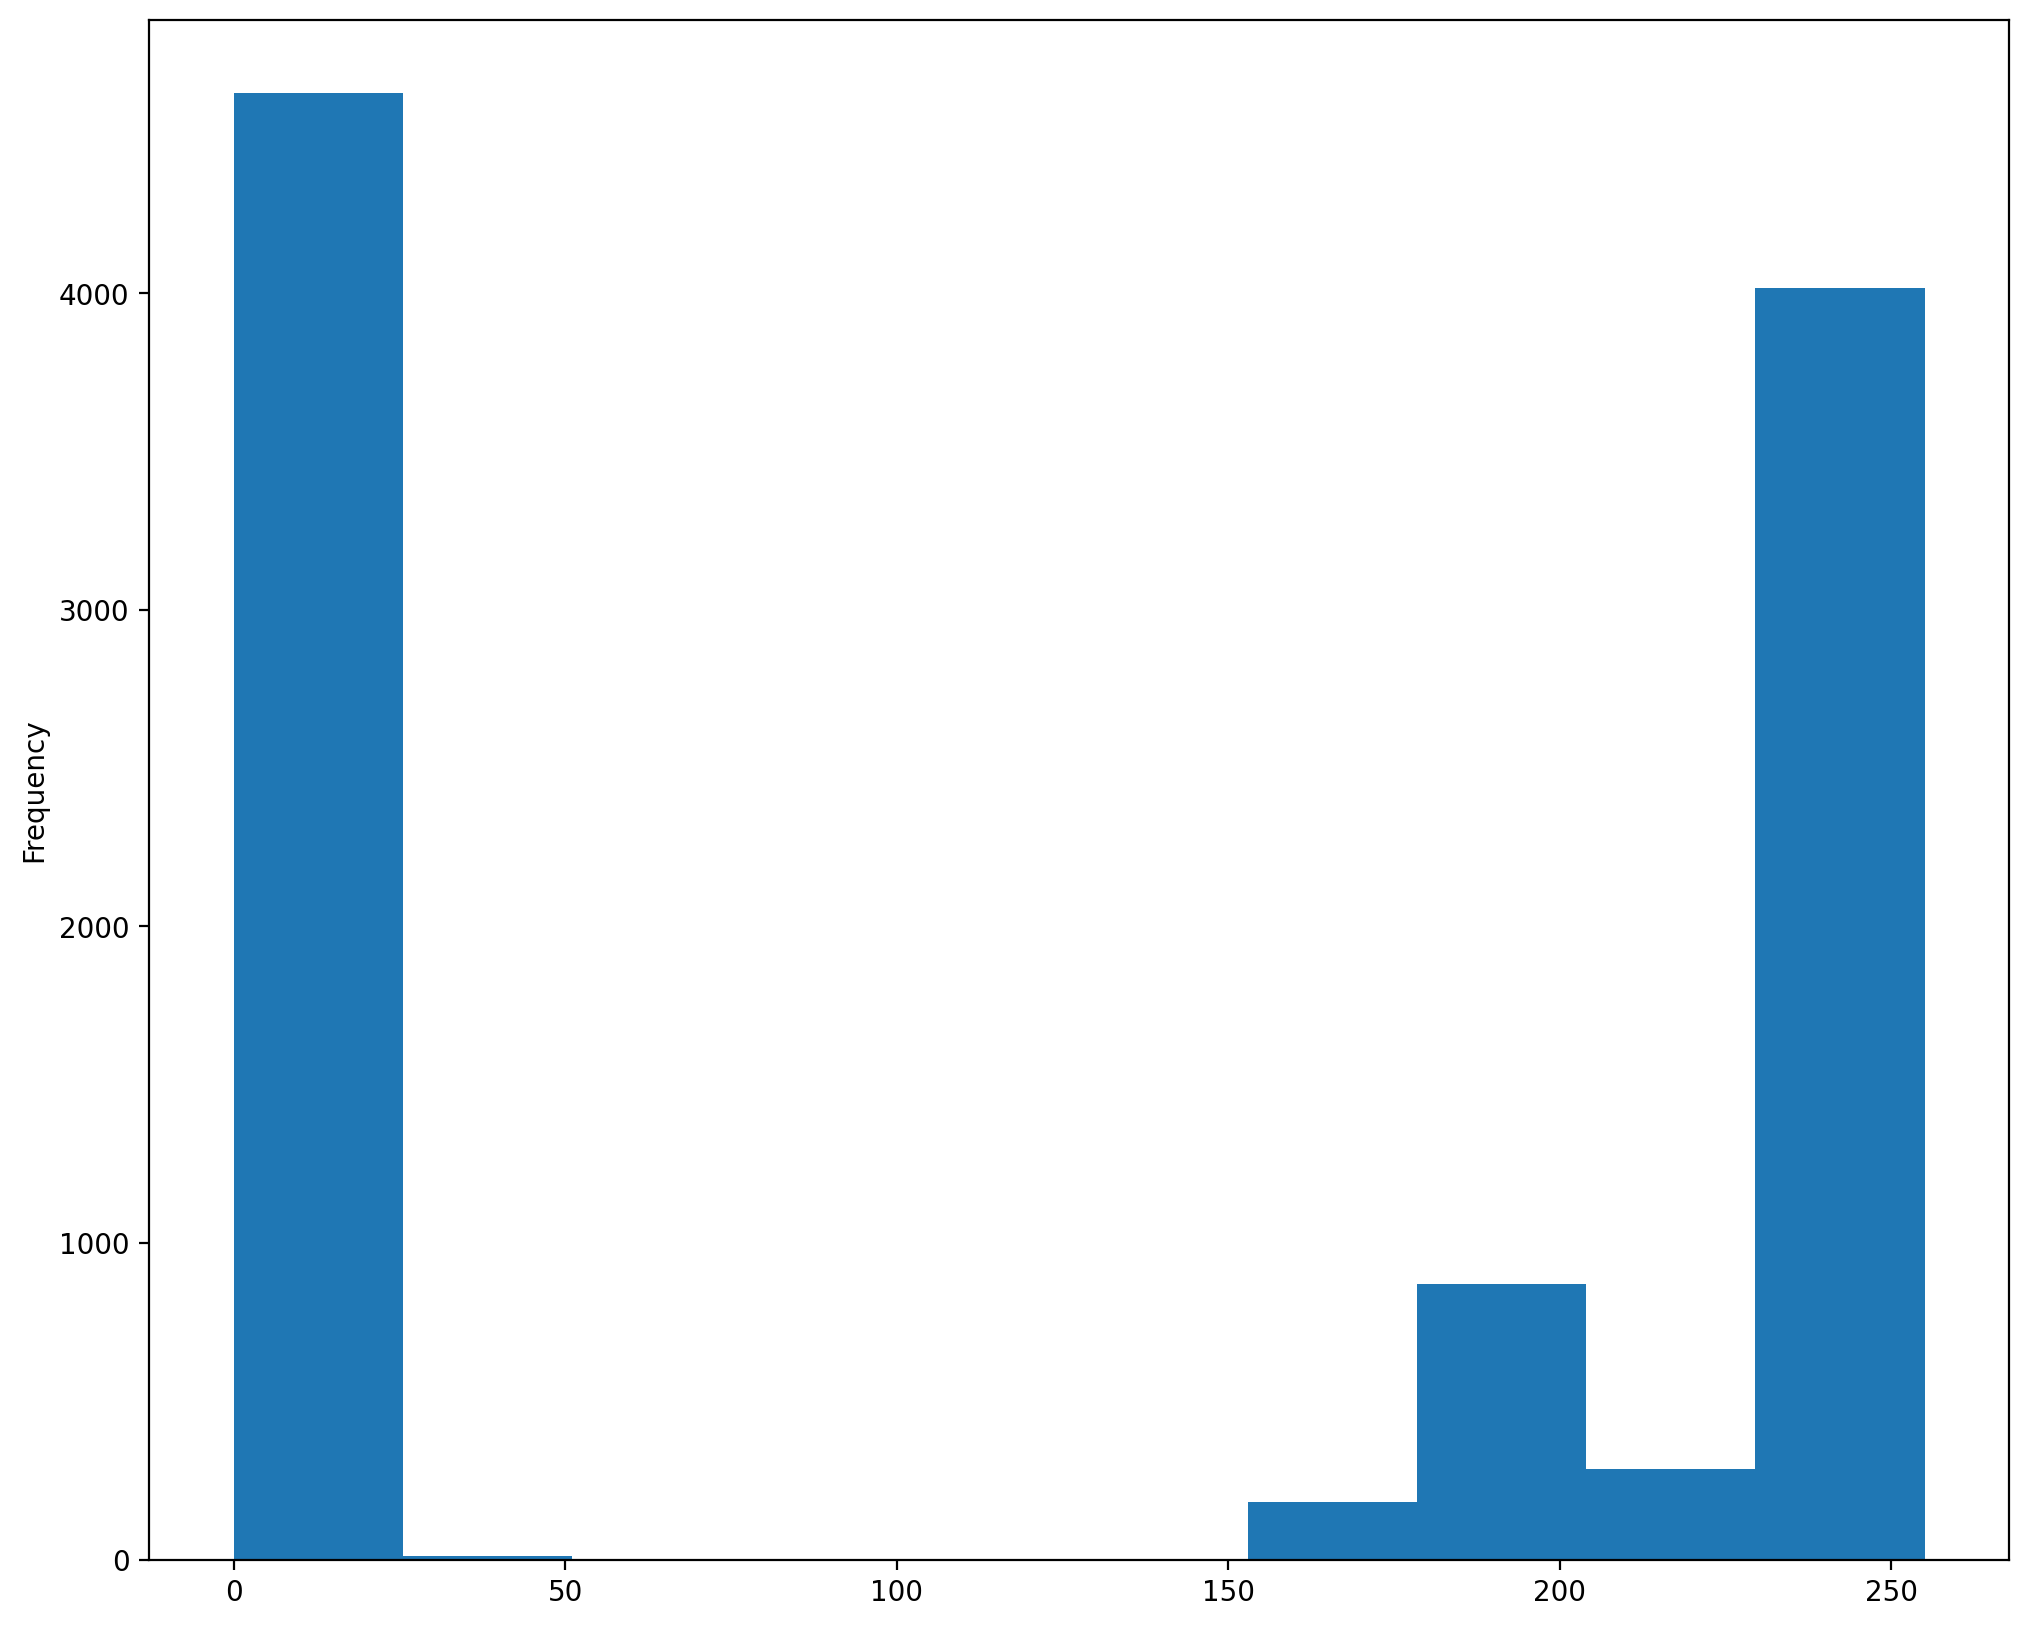

In [25]:
df.drop('label', axis=1).stack().plot.hist()

# Map extracted alphabets to their output labels

### Method 1: Image classification with image generation

#### Image Generation

For those labels with only one example

In [27]:
any((df.drop('label', axis=1) == 100).values.flatten())

False

In [28]:
# Get mask for all identifying pixels
mask = (df.drop('label', axis=1) < 100)

# get all values in that mask
subsample_values = df.drop('label', axis=1).where(mask).values.flatten()
subsample_values = sorted(subsample_values[~np.isnan(subsample_values)])

Iteration for image generation

In [29]:
num_samples_to_generate = 500
num_samples_to_generate_test = 50
column_names = list(set(indexes))

train_df = pd.DataFrame([])
test_df = pd.DataFrame([])

for label in column_names:
    # Get label values using mask
    img_df = df[df['label'] == label].drop('label', axis=1)
    
    # Display original image
    display(Image.fromarray(np.uint8(img_df.iloc[0].values.reshape(10,8))))
    
    # If there is only 1 example, use values extracted from the black pixels of all examples (i.e. A-Z, 0-9)
    if img_df.shape[0] == 1:
        # Define dataframe to collect all generated examples
        df_to_concat = pd.DataFrame([label for _ in range(num_samples_to_generate)], columns=['label'])
        test_df_to_concat = pd.DataFrame([label for _ in range(num_samples_to_generate_test)], columns=['label'])
        # Iterate through each pixel
        for col in img_df.columns:
            # If pixel is considered black or close to black
            if img_df[col].iloc[0] < 100:
                # Random selection from all accumulated values extracted from the black pixels of all examples to generate new pixel
                # Select up to stated amount 'num_samples_to_generate' without replacement
                concat_col = pd.Series(np.random.choice(subsample_values, size=num_samples_to_generate, replace=False))
                test_concat_col = pd.Series(np.random.choice(subsample_values, size=num_samples_to_generate_test, replace=False))
            else: # For the case when pixel is for background of captcha
                # Random selection from all accumulated values extracted from the background pixels of all examples to generate new pixel
                # Select up to stated amount 'num_samples_to_generate' without replacement
                concat_col = pd.Series([img_df[col].iloc[0] for _ in range(num_samples_to_generate)])
                test_concat_col = pd.Series([img_df[col].iloc[0] for _ in range(num_samples_to_generate_test)])
            # Concatenate generated values to dataframe
            df_to_concat = pd.concat([df_to_concat, concat_col], axis=1)
            test_df_to_concat = pd.concat([test_df_to_concat, test_concat_col], axis=1)
        # Define columns of the generated examples in this datafram
        df_to_concat.columns = df.columns
        test_df_to_concat.columns = df.columns
        
        # Display one example of generated examples
        display(Image.fromarray(np.uint8(df_to_concat.drop('label', axis=1).iloc[99].values.reshape(10,8))))
        display(Image.fromarray(np.uint8(test_df_to_concat.drop('label', axis=1).iloc[0].values.reshape(10,8))))
        
        # Concatenate all examples for training and test
        train_df = pd.concat([train_df, df[df['label'] == label], df_to_concat], axis=0, ignore_index=True)
        test_df = pd.concat([test_df, test_df_to_concat], axis=0, ignore_index=True)
    else:
        # Case when this alphabet or number has more than one example
        df_to_concat = pd.DataFrame([label for _ in range(num_samples_to_generate)], columns=['label'])
        test_df_to_concat = pd.DataFrame([label for _ in range(num_samples_to_generate_test)], columns=['label'])
        
        for col in img_df.columns:
            # Obtain max and minimum value for that pixel obtained across all pixels for that particular alphabet or number
            low = img_df[col].min()
            high = img_df[col].max()
            
            # If no variation of value in that pixel
            if low == high:
                # Generate the same number
                concat_col = pd.Series([low for _ in range(num_samples_to_generate)])
                test_concat_col = pd.Series([low for _ in range(num_samples_to_generate_test)])
            else:
                # If there are variations
                # Random sample integers between minimum and maximum seen 
                # Sample up to stated amount 'num_samples_to_generate'
                concat_col = pd.Series(np.random.randint(low=low, high=high, size=num_samples_to_generate))
                test_concat_col = pd.Series(np.random.randint(low=low, high=high, size=num_samples_to_generate_test))
            # Concatenate generated pixels
            df_to_concat = pd.concat([df_to_concat, concat_col], axis=1)
            test_df_to_concat = pd.concat([test_df_to_concat, test_concat_col], axis=1)
            
        # Define columns
        df_to_concat.columns = df.columns
        test_df_to_concat.columns = df.columns
        
        # Display an example of generated images
        display(Image.fromarray(np.uint8(df_to_concat.drop('label', axis=1).iloc[99].values.reshape(10,8))))
        display(Image.fromarray(np.uint8(test_df_to_concat.drop('label', axis=1).iloc[0].values.reshape(10,8))))
        
        # Concatenate to training and test dataframes
        train_df = pd.concat([train_df, df[df['label'] == label], df_to_concat], axis=0, ignore_index=True)
        test_df = pd.concat([test_df, test_df_to_concat], axis=0, ignore_index=True)
        # print(img_df.iloc[0].values.reshape(10,8) - df_to_concat.drop('label', axis=1).iloc[99].values.reshape(10,8))
    # break

In [30]:
train_df.shape

(18125, 81)

In [31]:
test_df.shape

(1800, 81)

#### Classification using XGBoost

Obtain training and test examples

In [34]:
y_train, x_train = train_df['label'], train_df.drop('label', axis=1)
y_test, x_test = test_df['label'], test_df.drop('label', axis=1)

Transform labels to one-hot-vectors

In [35]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

Reshape for VGG feature extraction

In [36]:
x_train = np.stack((x_train.values.reshape(-1,10,8),)*3, axis=-1)
x_test = np.stack((x_test.values.reshape(-1,10,8),)*3, axis=-1)
# stacked_img = np.stack((img,)*3, axis=-1)

In [37]:
x_train.shape

(18125, 10, 8, 3)

Resize image for VGG16 feature extraction

In [38]:
xt = []
xte = []

for img in x_train:
    # display(Image.fromarray(np.uint8(img)).resize((40,32)))
    img = np.array(Image.fromarray(np.uint8(img)).resize((32,40))) / 255.0
    xt.append(img)
    
for img in x_test:
    # display(Image.fromarray(np.uint8(img)).resize((40,32)))
    img = np.array(Image.fromarray(np.uint8(img)).resize((32,40))) / 255.0
    xte.append(img)


In [39]:
img.shape

(40, 32, 3)

Feature Extraction using VGG16

In [39]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(40, 32, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
# VGG_model.summary()  #Trainable parameters will be 0


#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(np.array(xt))

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

567/567 [==============================] - 204s 359ms/step


In [40]:
X_for_training.shape

(18125, 512)

XGBoost classification

In [41]:
model = xgb.XGBClassifier()
model.fit(X_for_training, y_train_encoded) #For sklearn no one hot encoding

/home/leeohnut/miniconda3/envs/jupyter/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:49:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [42]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(np.array(xte))
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

57/57 [==============================] - 19s 337ms/step


In [43]:
#Now predict using the trained RF model. 
y_pred = model.predict(X_test_features)

Obtain scores and transform one-hot-vector predictions to label values

In [44]:
f1 = round(f1_score(y_test_encoded, y_pred, average='weighted') * 100, 2)
acc = round(accuracy_score(y_test_encoded, y_pred) * 100, 2)
#Inverse le transform to get original label back. 
prediction = le.inverse_transform(y_pred)

Confusion Matrix for better visualization of prediction results

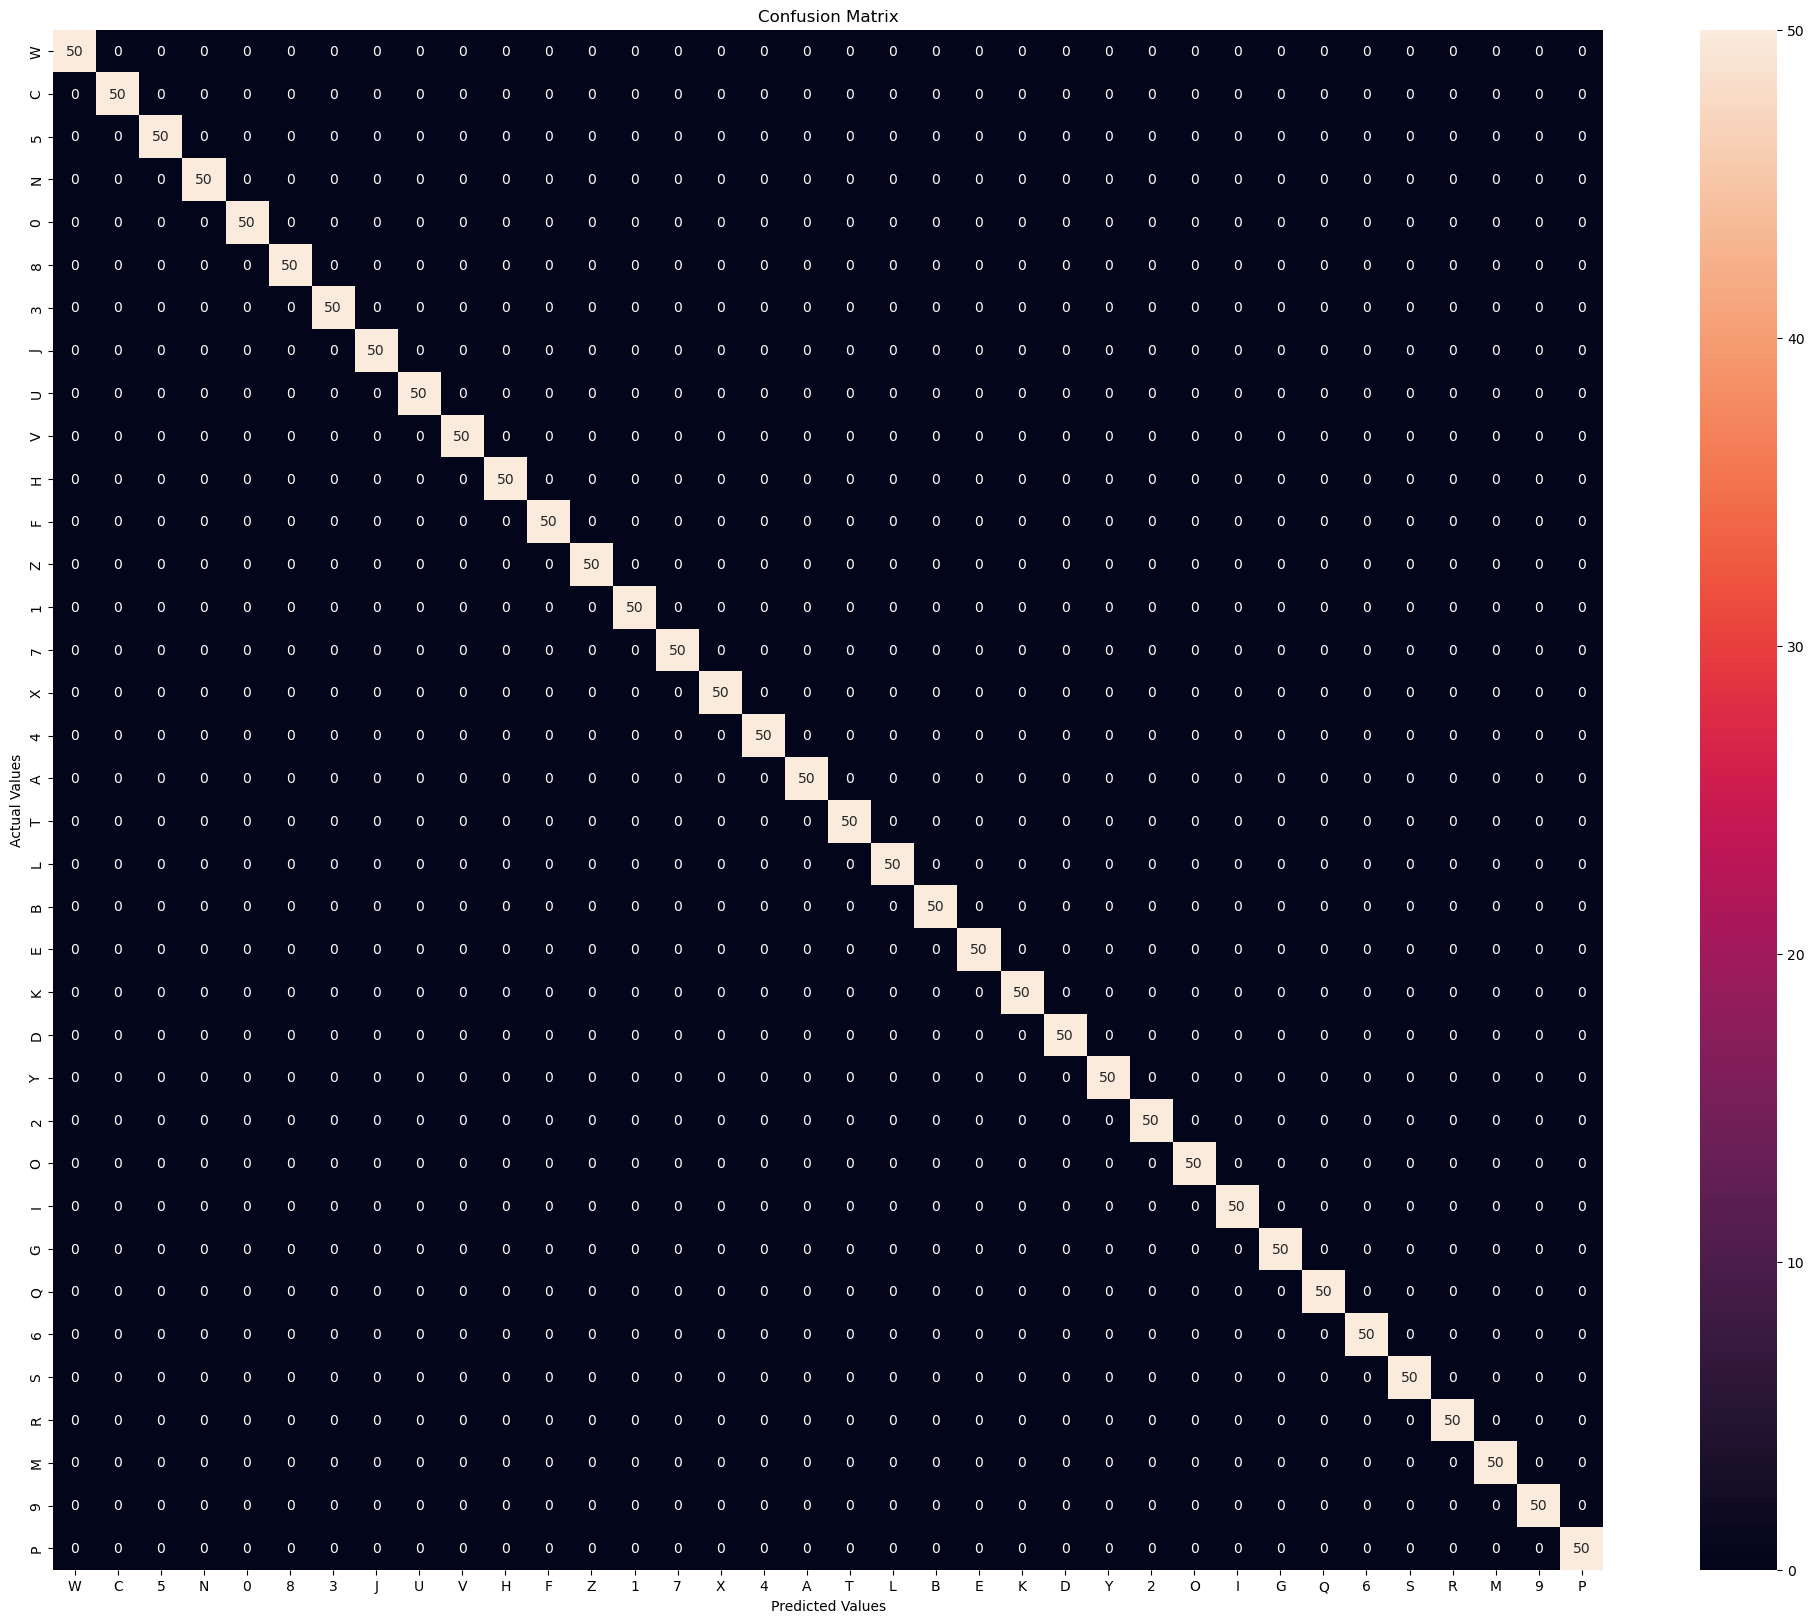

In [45]:
cm = confusion_matrix(y_test_encoded, y_pred)
cm_df = pd.DataFrame(cm,
                     index=list(y_test.unique()),
                     columns=list(y_test.unique()),
                    )
plt.figure(figsize=(25, 20))
sns.heatmap(cm_df, annot=True)
plt.title(f'Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
# plt.savefig(f'mindef_plots/confusion_matrix_{mn}.png')
plt.show()

Prediction results look decent as no errors detected

F1 and Accuracy score

In [46]:
f1, acc

(100.0, 100.0)

Save the model

In [47]:
model.save_model('XGB_IMDA.json')

In [48]:
import pickle

preprocessing_d = {'masks':masks, 'label_encoder':le, 'VGG16': VGG_model}

pickle.dump(preprocessing_d, open('preprocessing_d.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://8275bfc4-8599-424f-a91c-8c31e73f471a/assets


INFO:tensorflow:Assets written to: ram://8275bfc4-8599-424f-a91c-8c31e73f471a/assets


#### Method 2: Similarity measure using threshold masking and XOR function as a scorer

Threshold Masking first

In [40]:
# Get mask for all label identifying pixels
df_wo_label = df.drop('label', axis=1)
mask = (df_wo_label < 100)

# Apply binary transform (If pixel is in mask, set as 1 else set as 0)
binary_df = df_wo_label.where(~mask, 1).where(mask, 0)
binary_df = pd.concat([binary_df, df['label']], axis=1)

# Check uniqueness and obtain XOR vector for each alphabet
alphabet_XOR = {label: None for label in column_names}

for label in column_names:
    alphabet_masked = binary_df[binary_df['label'] == label].drop('label', axis=1)
    checker = all([all(alphabet_masked.values[0] == arr) for arr in alphabet_masked.values])
    if not checker:
        print(label)
        
    alphabet_XOR[label] = np.int64(alphabet_masked.values[0])

Example of weights for alphabet 'A'

In [41]:
alphabet_XOR['A']

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1])

Do XOR for all combinations of alphabets and numbers

In [42]:
import itertools
from tqdm import tqdm

num_of_combinations = len([1 for _ in itertools.combinations(alphabet_XOR.keys(), 2)])

alphanumerals = sorted(list(alphabet_XOR.keys()))

res_df = pd.DataFrame(index=alphanumerals, columns=alphanumerals)

for subset in tqdm(itertools.combinations(alphabet_XOR.keys(), 2), total=num_of_combinations):
    xor1 = alphabet_XOR[subset[0]]
    xor2 = alphabet_XOR[subset[1]]
    # print(1 - sum(np.logical_xor(xor1, xor2)) / len(xor1))
    # print(1 - sum(np.logical_xor(xor1, xor1)) / len(xor1))
    # print(1 - sum(np.logical_xor(xor2, xor2)) / len(xor1))
    
    res_df.loc[subset[0], subset[1]] = (1 - sum(np.logical_xor(xor1, xor2)) / len(xor1))
    res_df.loc[subset[1], subset[0]] = (1 - sum(np.logical_xor(xor2, xor1)) / len(xor1))
    res_df.loc[subset[0], subset[0]] = (1 - sum(np.logical_xor(xor1, xor1)) / len(xor1))
    res_df.loc[subset[1], subset[1]] = (1 - sum(np.logical_xor(xor2, xor2)) / len(xor1))

100%|████████████████████████████████████████████████████████████████████████████████| 630/630 [00:00<00:00, 990.95it/s]


Convert to floating point values

In [43]:
res_df = res_df.astype('float')

Plot of all comparisons to determine if method is feasible (i.e. applying XOR for each vector of alphabets after masking each pixel would yield distinct results for the target label; The values for each alphabet/number comparisons outputs 1 only for the same alphabet/number compared against and less than 1 for differing comparisons)

/home/leeohnut/miniconda3/envs/jupyter/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  after removing the cwd from sys.path.


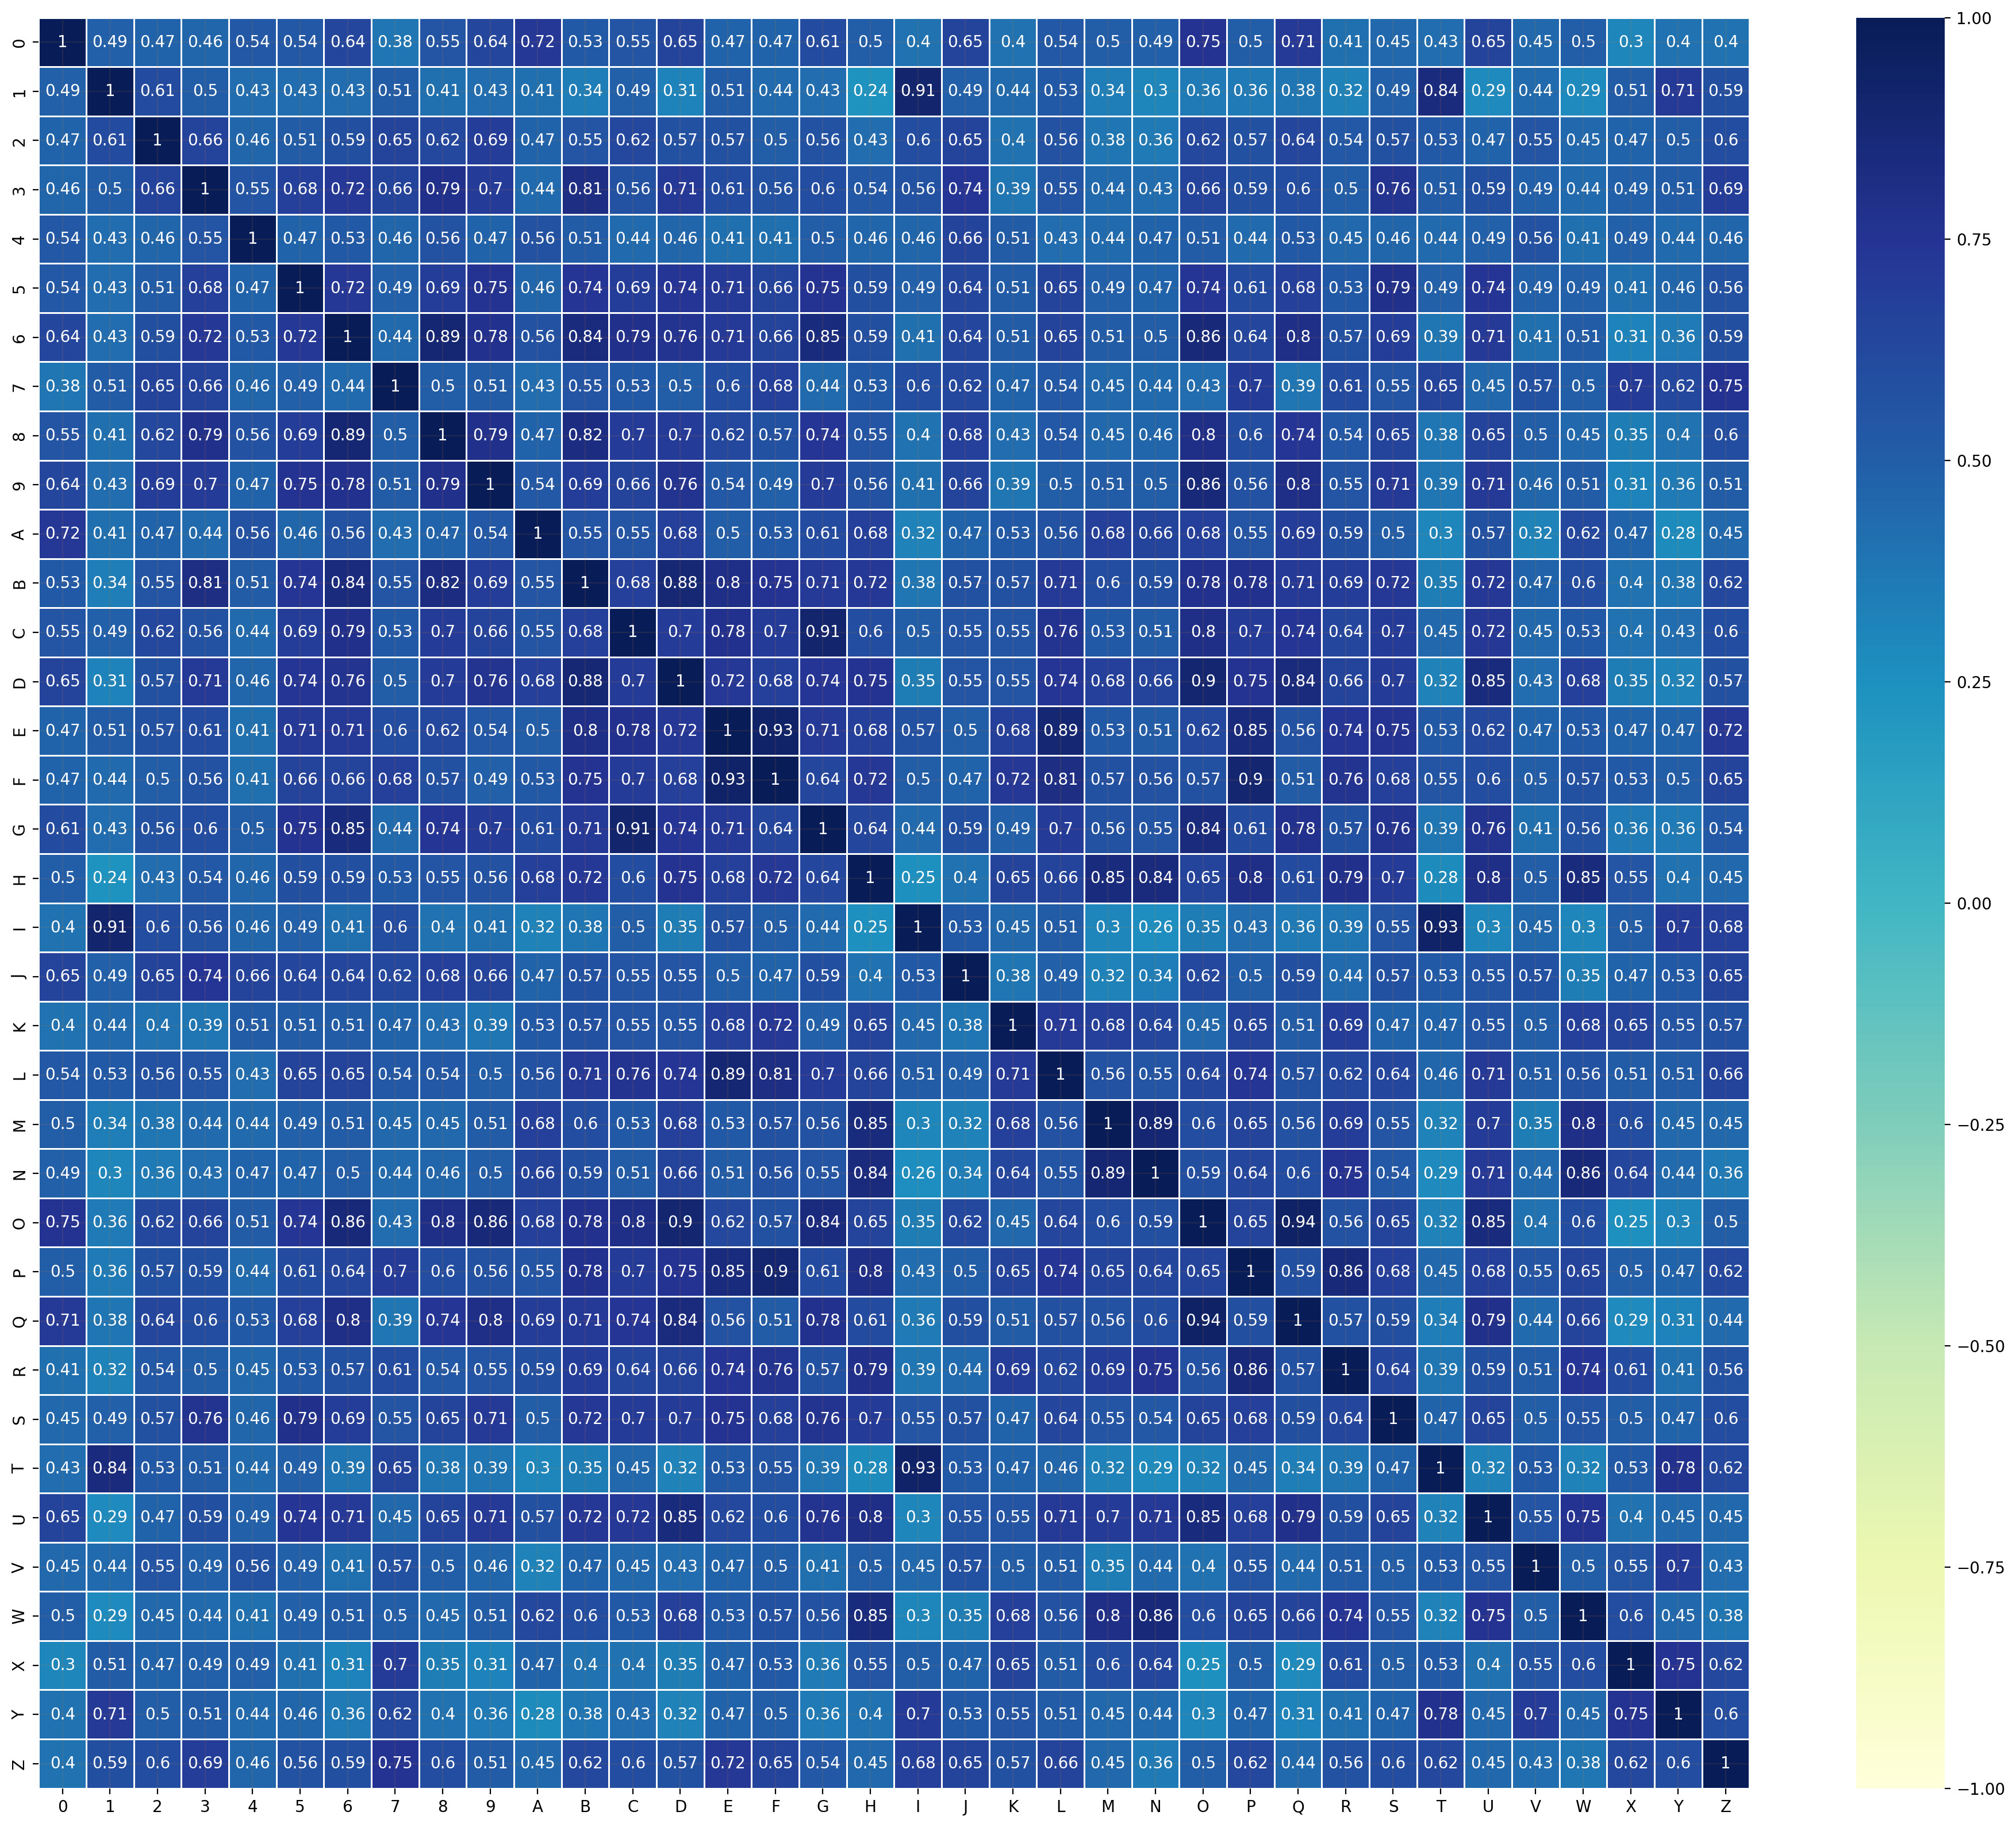

In [44]:
plt.figure(figsize = (24,20))

sns.heatmap(res_df, annot = True, vmin=-1, vmax=1, cmap="YlGnBu", linewidths=.5)
plt.grid(b=True, color='#f68c1f', alpha=0.1)
plt.show()

In [128]:
tmp = []
y_labels = []
for k, val in alphabet_XOR.items():
    y_labels.append(k)
    tmp.append(val)

alphabet_XOR_weights = np.stack(tmp, axis=0)
print(alphabet_XOR_weights.shape)
y_labels = np.array(y_labels)

(36, 80)


In [155]:
y_labels == 'Y'

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False])

In [136]:
for example, label in zip(binary_df.drop('label', axis=1).values, binary_df['label'].values):
    # print(example, label)
    example = np.stack((example,)*len(y_labels), axis=0)
    y_results = (1 - np.sum(np.logical_xor(example, alphabet_XOR_weights), axis=0) / len(xor1))
    # print((1 - np.sum(np.logical_xor(example, alphabet_XOR_weights), axis=1) / 80) == 1)
    print(y_labels[(1 - np.sum(np.logical_xor(example, alphabet_XOR_weights), axis=1) / 80) == 1][0] == label)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [162]:
weights_and_labels = {'XOR': alphabet_XOR_weights, 'labels': y_labels, 'masks': masks}

pickle.dump(weights_and_labels, open('weights_and_labels.pkl', 'wb'))

# Apply on test image

In [137]:
import os
import pickle
import pandas as pd
import numpy as np
from PIL import Image, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

#Models
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier # decision tree
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting
from keras.applications.vgg16 import VGG16

# Metrics
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [163]:
filepath = 'sampleCaptchas/input'
for file in os.listdir(filepath):
    if file.endswith('100.jpg'):
        image = Image.open(os.path.join(filepath, file))
        
preprocessing_d = pickle.load(open('preprocessing_d.pkl', 'rb'))
masks = preprocessing_d['masks']
le = preprocessing_d['label_encoder']
VGG_model = preprocessing_d['VGG16']

model = xgb.XGBClassifier()
model.load_model('XGB_IMDA.json')

weights_and_labels = pickle.load(open('weights_and_labels.pkl', 'rb'))
alphabet_XOR_weights = weights_and_labels['XOR']
y_labels = weights_and_labels['labels']
        
g_image = ImageOps.grayscale(image)
numpy_image = np.array(g_image)

alphabet_imgs = []
for mask in masks:
    init_image = numpy_image[mask].reshape(10,8)
    alpha = np.stack((numpy_images[0][mask].reshape(10,8),)*3, axis=-1)
    alpha = np.array(Image.fromarray(np.uint8(alpha)).resize((32,40))) / 255.0

    feature_extractor = VGG_model.predict(alpha.reshape(1, 40, 32, 3))
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)
                     
    y_pred = model.predict(features)
    prediction = le.inverse_transform(y_pred)[0]
    
    pd_mask = (numpy_image[mask] < 100)
    flattened_image = pd.Series(numpy_image[mask]).where(~pd_mask, 1).where(pd_mask, 0)
    flattened_image = np.stack((flattened_image.values,)*len(y_labels), axis=0)
    y_results = (1 - np.sum(np.logical_xor(flattened_image, alphabet_XOR_weights), axis=1) / 80)
    XOR_y_pred = y_labels[np.argmax(y_results)]
    
    print('image input:\n')
    display(Image.fromarray(np.uint8(init_image)))
    print(f'image prediction (XGBoost): {prediction}\n')
    print(f'image prediction (XOR): {XOR_y_pred}\n')

1/1 [==============================] - 0s 144ms/step
image input:



image prediction (XGBoost): Y

image prediction (XOR): Y

1/1 [==============================] - 0s 185ms/step
image input:



image prediction (XGBoost): M

image prediction (XOR): M

1/1 [==============================] - 0s 129ms/step
image input:



image prediction (XGBoost): B

image prediction (XOR): B

1/1 [==============================] - 0s 163ms/step
image input:



image prediction (XGBoost): 1

image prediction (XOR): 1

1/1 [==============================] - 0s 235ms/step
image input:



image prediction (XGBoost): Q

image prediction (XOR): Q



# Conclusion:

A simple algorithm using XOR function can yield accurate results more efficiently and effectively as seen in Method 2. This only works in this case example as position, font, spacing, number of characters, background & foreground, and structure of the characters do not change. 

In the event there are any variations to position and spacing, a dynamic algorithm to extract them is required of the masks

In the event there are changes in fonts or structures, XOR method would not work would and a machine learning method to identify each alphabet and number individually (i.e. XGBoost) would do the trick.

In the event there are changes in background and foreground, no masking to extract the individual alphabets are possible and a full classification to output all characters at once. Or else, extensive methods to extract the individual alphabets/numbers are first processed and we can defer back to classifying one alphabet at a time.